# EGT Heads Demo
This notebook runs training, measures per-head payoffs via ablation, and evolves head shares with replicator dynamics. It also visualizes loss, replicator trajectories, and attention maps.

In [1]:
import sys, os
sys.path.append(os.path.abspath(".."))  # repo root

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from models.transformer import TinyTransformerBlock
from utils.payoff import measure_head_payoffs, capture_attention_maps
from egt.replicator import Replicator



In [2]:
# Hyperparameters
seq_len, vocab_size, d_model = 12, 32, 48
num_heads, dim_ff = 4, 96
epochs = 40
measure_every = 5
lr = 1e-3



In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
embedding = nn.Embedding(vocab_size, d_model).to(device)
block = TinyTransformerBlock(d_model=d_model, num_heads=num_heads, dim_ff=dim_ff).to(device)
output_layer = nn.Linear(d_model, vocab_size).to(device)
criterion = nn.CrossEntropyLoss()
params = list(embedding.parameters()) + list(block.parameters()) + list(output_layer.parameters())
optimizer = optim.Adam(params, lr=lr)

In [4]:
# Replicator init
x = torch.ones(num_heads, device=device) / num_heads
rep = Replicator(num_heads=num_heads, mutation=0.05)
losses = []
payoff_history = []

In [5]:
for step in range(epochs):
    x_tokens = torch.randint(0, vocab_size, (32, seq_len), device=device)
    x_embed = embedding(x_tokens)
    out = block(x_embed, head_weights=x)
    logits = output_layer(out)
    loss = criterion(logits.view(-1, vocab_size), x_tokens.view(-1))
    optimizer.zero_grad(); loss.backward(); optimizer.step()
    losses.append(loss.item())
    if (step + 1) % measure_every == 0:
        with torch.no_grad():
            stats = measure_head_payoffs(embedding, block, output_layer, x_tokens, criterion)
            payoffs = stats['payoffs']
            payoff_history.append(payoffs.cpu())
            x = rep.step(x, payoffs)

TypeError: TinyTransformerBlock.forward() got an unexpected keyword argument 'head_weights'

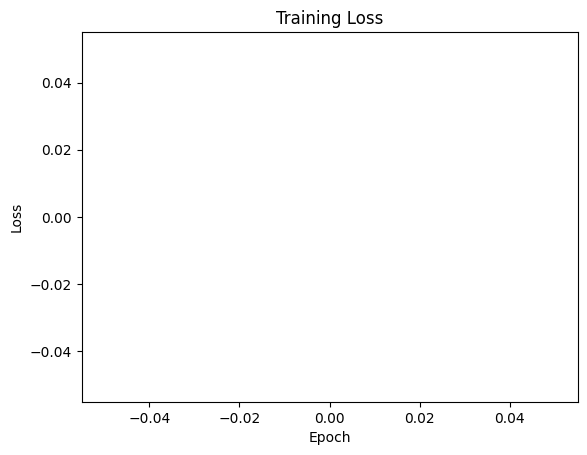

In [6]:
# Plot loss
plt.figure()
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [7]:
# Plot replicator trajectories
hist = rep.get_history()
if hist.nelement() != 0:
    for h in range(hist.shape[1]):
        plt.figure()
        plt.plot(hist[:, h])
        plt.title(f'Replicator Share - Head {h}')
        plt.xlabel('Measurement Step')
        plt.ylabel('Population Share')
        plt.show()

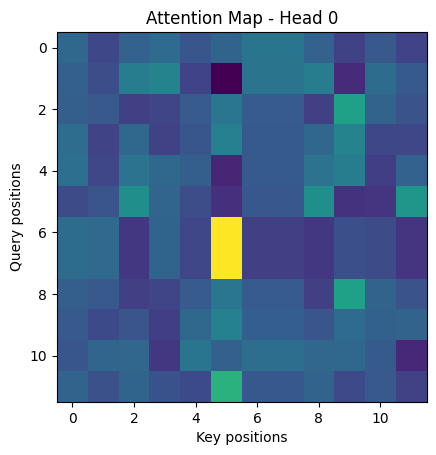

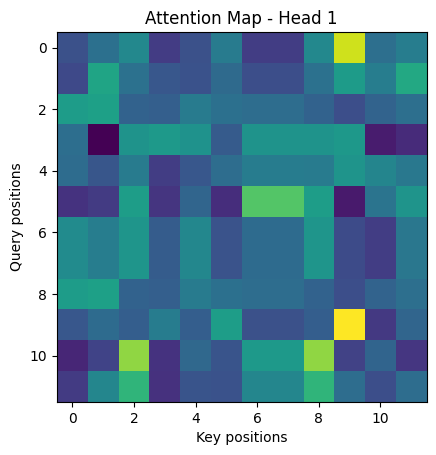

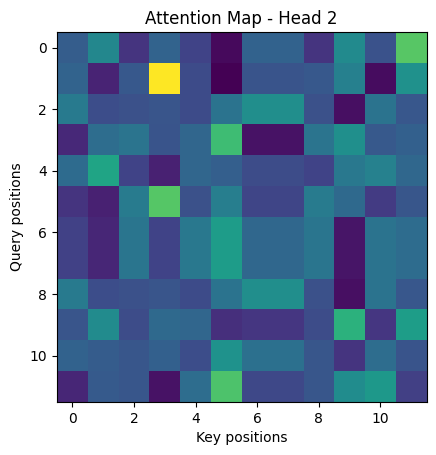

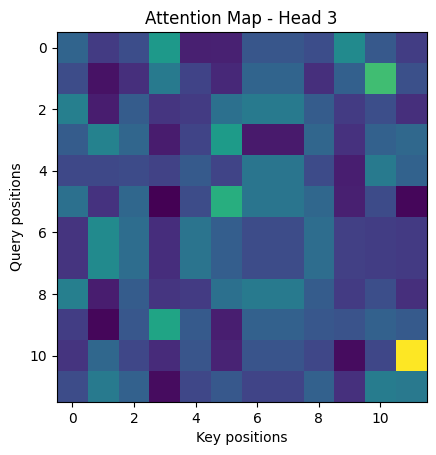

In [8]:
# Attention map snapshot
with torch.no_grad():
    x_tokens = torch.randint(0, vocab_size, (1, seq_len), device=device)
    attn = capture_attention_maps(block, embedding(x_tokens))
attn = attn[0].cpu()
for h in range(attn.shape[0]):
    plt.figure()
    plt.imshow(attn[h])
    plt.title(f'Attention Map - Head {h}')
    plt.xlabel('Key positions')
    plt.ylabel('Query positions')
    plt.show()

## Notes
- **Payoff = base loss − ablation loss** (positive means the head helps).
- **Replicator–mutator** prevents collapse and keeps exploring.
- Per-head weights (`head_weights`) let population shares influence the forward pass.